### Let's analysis theta power during running of EEG signal in Lomi data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import h5py
import numpy as np
from scipy.fftpack import fft
from scipy.signal import welch
from scipy.ndimage import gaussian_filter1d


%load_ext autoreload
%autoreload 2


### Load eeg data, position, and head direction data

In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox']).squeeze()
        ppoy = np.array(light1['poy']).squeeze()
        pot = np.array(light1['pot']).squeeze()
        poh = np.array(light1['poh']).squeeze()
        pov = np.array(light1['pov']).squeeze()
        
        eeg = np.array(sdata['eeg']).squeeze()
        eegVolts = np.array(sdata['eegVolts']).squeeze()
        eeg_filtered = np.array(sdata['eeg_filtered']).squeeze()
        eegtimes = np.array(sdata['thetatimes']).squeeze()

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'eeg': eeg,
            'eegVolts': eegVolts,
            'eeg_filtered': eeg_filtered,
            'eegtimes': eegtimes
        }

        return data_dict

def compute_theta_power_welch(eeg, fs=250, theta_band=(6, 12)):
    freqs, psd = welch(eeg, fs=fs, nperseg=len(eeg)//2)
    theta_indices = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
    return np.max(psd[theta_indices]), freqs[theta_indices][np.argmax(psd[theta_indices])]


def compute_theta_power(eeg, fs=250, theta_band=(6, 12), gaussian_std=0.5, absolute_power=False):
    """
    Compute the maximum theta power (either absolute or z-scored) and apply log transformation if required.

    Parameters:
    eeg (numpy array): EEG signal (1D array)
    fs (int): Sampling frequency in Hz (default: 250 Hz)
    theta_band (tuple): Frequency range for theta band (default: (6, 12) Hz)
    gaussian_std (float): Standard deviation for Gaussian smoothing (default: 0.5 Hz)
    absolute_power (bool): If True, returns absolute theta power; if False, returns z-scored power.
    log_transform (bool): If True and absolute_power is True, applies log10 transform.

    Returns:
    peak_theta_power (float): Maximum theta power (absolute/log or z-scored) in the 6-12 Hz range
    peak_theta_frequency (float): Corresponding frequency of peak theta power
    """
    # Compute FFT power spectrum
    N = len(eeg)
    freqs = np.fft.fftfreq(N, 1/fs)[:N//2]
    fft_vals = np.abs(fft(eeg))[:N//2]**2  # Compute power spectrum (magnitude squared)

    # Apply Gaussian smoothing
    freq_resolution = freqs[1] - freqs[0]
    smoothed_psd = gaussian_filter1d(fft_vals, sigma=gaussian_std / freq_resolution)

    if not absolute_power:
        # Apply Z-score normalization ONLY for z-score mode
        smoothed_psd = (smoothed_psd - np.mean(smoothed_psd)) / np.std(smoothed_psd)

    # Extract theta band power
    theta_indices = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
    theta_power = smoothed_psd[theta_indices]

    # Get peak theta power
    peak_theta_power = np.max(theta_power)

    # Apply log transformation ONLY if absolute power is used to get log10 power in dB
    if absolute_power:
        session_mean_power = np.mean(smoothed_psd)  # Mean of full power spectrum
        peak_theta_power = peak_theta_power / session_mean_power  # Normalize
        peak_theta_power = 10 * np.log10(peak_theta_power)

    # Find peak theta frequency
    peak_theta_frequency = freqs[theta_indices][np.argmax(theta_power)]

    return peak_theta_power, peak_theta_frequency


#Extract Periods Based on Speed
def extract_speed_periods(v, t, speed_range=(0, 10), dur=1):
    """
    Extracts periods where the animal's speed is within a given range.

    Parameters:
    v (numpy array): Speed values at each timestamp.
    t (numpy array): Corresponding timestamps.
    speed_range (tuple): Speed range (min, max) to extract periods (default: (0,10)).
    dur (float): Minimum duration for valid periods in seconds (default: 1s).

    Returns:
    list of tuples: [(start_time, end_time), ...] for periods meeting the criteria.
    """
    v_min, v_max = speed_range
    valid_indices = (v >= v_min) & (v <= v_max)  # Find indices where speed is in range

    periods = []
    if np.any(valid_indices):  # Check if any valid indices exist
        change_points = np.diff(valid_indices.astype(int))  # Detect transitions
        start_indices = np.where(change_points == 1)[0] + 1  # Transition into range
        end_indices = np.where(change_points == -1)[0] + 1  # Transition out of range

        # Handle edge cases where valid period starts at index 0 or ends at last index
        if valid_indices[0]:  # If first index is in range
            start_indices = np.insert(start_indices, 0, 0)
        if valid_indices[-1]:  # If last index is in range
            end_indices = np.append(end_indices, len(v))

        # Convert indices to time and filter by duration
        for start, end in zip(start_indices, end_indices):
            if (t[end - 1] - t[start]) >= dur:  # Ensure period is at least `dur` long
                periods.append((t[start], t[end - 1]))

    return periods

def compute_mean_theta_power_by_speed(v, t, eeg, eegtimes, fs=250, speed_range=(0, 10), dur=1, absolute_power=False):
    """
    Extracts EEG periods based on speed range, computes theta power and frequency, 
    and returns the mean values across all periods.

    Parameters:
    v (numpy array): Speed values at each timestamp.
    t (numpy array): Corresponding timestamps for speed.
    eeg (numpy array): EEG signal.
    eegtimes (numpy array): Corresponding timestamps for EEG.
    fs (int): Sampling frequency of EEG (default: 250 Hz).
    speed_range (tuple): Speed range (min, max) to extract periods (default: (0,10)).
    dur (float): Minimum duration for valid periods in seconds (default: 1s).

    Returns:
    mean_theta_power (float): Mean theta power across valid periods.
    mean_theta_frequency (float): Mean theta frequency across valid periods.
    """
    # Extract valid speed periods
    speed_periods = extract_speed_periods(v, t, speed_range=speed_range, dur=dur)

    # Initialize lists for theta power and frequency
    theta_power_periods = []
    theta_freq_periods = []

    # Compute theta power and frequency for each valid period
    for start, end in speed_periods:
        eeg_period = eeg[(eegtimes >= start) & (eegtimes <= end)]
        if len(eeg_period) > 0:  # Ensure period has data
            theta_power, theta_freq = compute_theta_power(eeg_period, fs=fs, absolute_power=absolute_power)
            #theta_power, theta_freq = compute_theta_power_welch(eeg_period, fs=fs)
            theta_power_periods.append(theta_power)
            theta_freq_periods.append(theta_freq)

    # Compute mean values
    mean_theta_power = np.mean(theta_power_periods) if theta_power_periods else np.nan
    mean_theta_frequency = np.mean(theta_freq_periods) if theta_freq_periods else np.nan

    return mean_theta_power, mean_theta_frequency


In [14]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

count = 0
stop_processing = False  # Flag to break both loops

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                count += 1
                file_path = os.path.join(subdir_path, file)
                #print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is None:
                    continue
                
                eeg = data_dict['eeg']
                eegVolts = data_dict['eegVolts']
                eeg_filtered = data_dict['eeg_filtered']
                eegtimes = data_dict['eegtimes']
                
                hd = data_dict['poh']
                t = data_dict['pot']
                x = data_dict['ppox']
                y = data_dict['ppoy']
                v = data_dict['pov']
                
                print(f"Rat: {ratname}")
                print(np.mean(eeg))
                
                if count > 1:
                    stop_processing = True
                    break
    if stop_processing:
        break
                

Rat: R652
0.005632247924804688
Rat: R652
0.000872039794921875


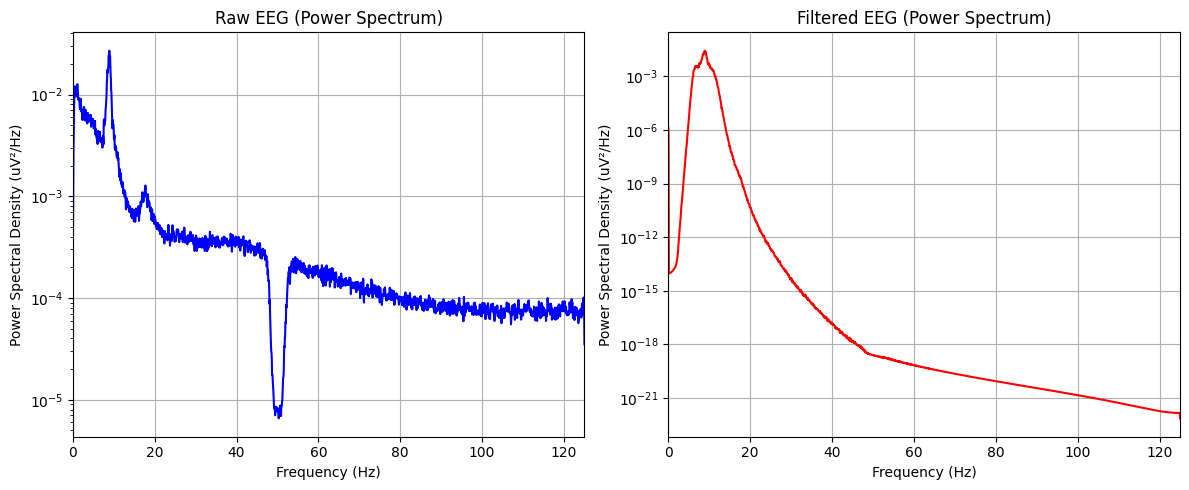

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Define parameters
fs = 250  # Sampling frequency (Hz)
nperseg = 4000  # Segment size (adjustable for efficiency)

# Compute power spectra using Welch’s method
freqs, psd_eeg = welch(eeg, fs=fs, nperseg=nperseg)
_, psd_eeg_filtered = welch(eeg_filtered, fs=fs, nperseg=nperseg)

# Plot power spectra
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Raw EEG Power Spectrum
axs[0].semilogy(freqs, psd_eeg, label='Raw EEG', color='b')  # Log scale for better visibility
axs[0].set_title('Raw EEG (Power Spectrum)')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power Spectral Density (uV²/Hz)')
axs[0].grid()
axs[0].set_xlim([0, 125])

# Filtered EEG Power Spectrum
axs[1].semilogy(freqs, psd_eeg_filtered, label='Filtered EEG', color='r')
axs[1].set_title('Filtered EEG (Power Spectrum)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Power Spectral Density (uV²/Hz)')
axs[1].grid()
axs[1].set_xlim([0, 125])

plt.tight_layout()
plt.show()


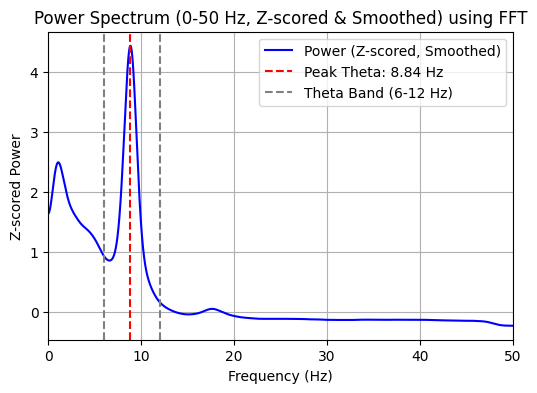

Peak Theta Power (Z-scored): 4.435609195366895
Peak Theta Frequency: 8.84 Hz


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.ndimage import gaussian_filter1d

# Define parameters
fs = 250  # Sampling frequency in Hz
theta_band = (6, 12)  # Theta frequency range
gaussian_bandwidth = 2  # Hz
gaussian_std = 0.5  # Hz

# Compute FFT power spectrum
N = len(eeg)  # Number of samples
freqs = np.fft.fftfreq(N, 1/fs)[:N//2]  # Get only positive frequencies
fft_vals = np.abs(fft(eeg))[:N//2]**2  # Compute power spectrum (magnitude squared)

# Z-score normalization of power spectrum
psd_z = (fft_vals - np.mean(fft_vals)) / np.std(fft_vals)

# Apply Gaussian smoothing
freq_resolution = freqs[1] - freqs[0]  # Frequency step size
smoothed_psd_z = gaussian_filter1d(psd_z, sigma=gaussian_std / freq_resolution)

# Extract theta band power
theta_indices = (freqs >= theta_band[0]) & (freqs <= theta_band[1])
theta_power_z = smoothed_psd_z[theta_indices]

# Find maximum theta power and corresponding frequency
peak_theta_power = np.max(theta_power_z)
peak_theta_frequency = freqs[theta_indices][np.argmax(theta_power_z)]

# Plot Z-scored and smoothed power spectrum (0-50 Hz range)
plt.figure(figsize=(6, 4))
plt.plot(freqs, smoothed_psd_z, label='Power (Z-scored, Smoothed)', color='b')
plt.axvline(peak_theta_frequency, color='r', linestyle='--', label=f'Peak Theta: {peak_theta_frequency:.2f} Hz')
plt.axvline(theta_band[0], color='gray', linestyle='dashed', label='Theta Band (6-12 Hz)')
plt.axvline(theta_band[1], color='gray', linestyle='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Z-scored Power')
plt.title('Power Spectrum (0-50 Hz, Z-scored & Smoothed) using FFT')
plt.legend()
plt.grid()
plt.xlim([0, 50])  # Set frequency range from 0 to 50 Hz
plt.show()

# Print peak theta power and frequency
print(f"Peak Theta Power (Z-scored): {peak_theta_power}")
print(f"Peak Theta Frequency: {peak_theta_frequency:.2f} Hz")


### We can see the raw eeg signal has been notch filtered at 50Hz. Below let's use the raw eeg to analysis

-44.284523


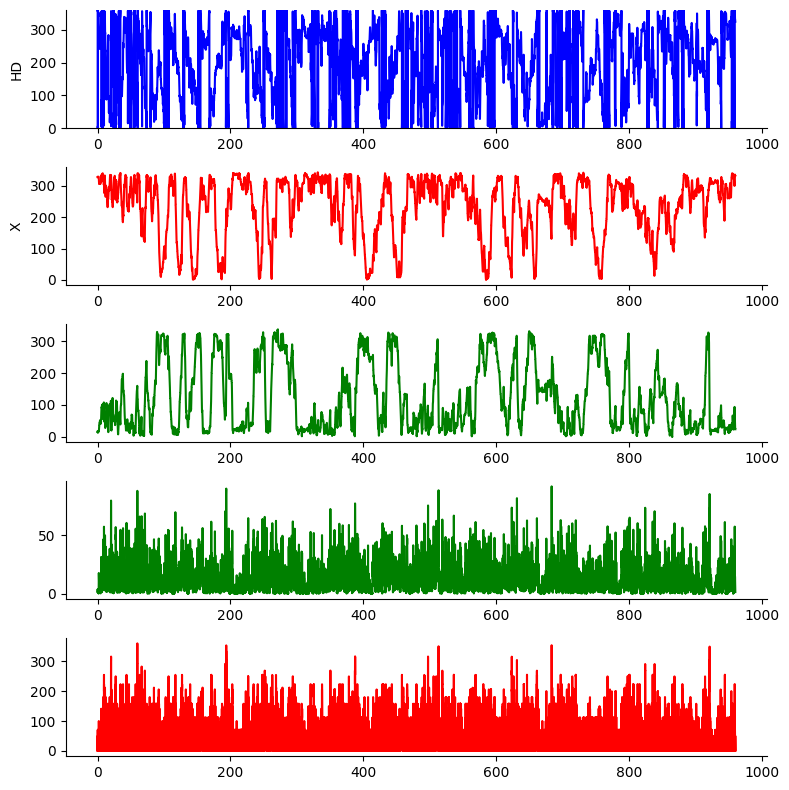

In [6]:
#plot the head direction and x location and y location over tim ein a 3*1 plot
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

# Head Direction vs. Time
axs[0].plot(t, hd, label='Head Direction', color='b')
axs[0].set_ylabel('HD')
axs[0].set_ylim([0, 360])

#calculate 

# X Location vs. Time
axs[1].plot(t, x, label='X Location', color='r')
axs[1].set_ylabel('X')

# Y Location vs. Time
axs[2].plot(t, y, label='Y Location', color='g')
axs[2].set_label('Y')

# velocity vs. Time
axs[3].plot(t, v, label='Velocity', color='g')
axs[3].set_label('V')

#calculate speeed from x and y location and overlap that with the precalculated velocity
speed = np.sqrt(np.diff(x)**2 + np.diff(y)**2) / np.diff(t)

axs[4].plot(t[:-1], speed, label='Speed', color='r')

#calculate the difference between the precalculated velocity and the calculated speed
diff = v[:-1] - speed

print(np.nanmean(diff))


sns.despine()
plt.tight_layout()


In [7]:
# check theta power in different speped bin, using 10 cm/s bin, [0,10], [10,20], [20,30], [30,40], [40,50]
# first extract periods when the speed in each bin, then calculate theta power in each bin using z-scored FFT
# So you need to write a function by taking in the eeg signal in a period, and return the theta power and peak frequency
# then apply this function to each period in each speed bin

In [7]:
#test
mean_theta_power, mean_theta_frequency = compute_mean_theta_power_by_speed(v, t, eeg, eegtimes, fs=fs, speed_range=(0, 10), dur=1)
print(f"Mean Theta Power (0-10 cm/s): {mean_theta_power}", f"Mean Theta Frequency: {mean_theta_frequency:.2f} Hz")

#test
peak_theta_power, peak_theta_frequency = compute_theta_power(eeg, fs=fs, 
                                                             theta_band=theta_band, 
                                                             gaussian_std=gaussian_std,
                                                             absolute_power=False)
print(f"Peak Theta Power (Z-scored): {peak_theta_power}", f"Peak Theta Frequency: {peak_theta_frequency:.2f} Hz")

Mean Theta Power (0-10 cm/s): 6.539174066030779 Mean Theta Frequency: 8.27 Hz
Peak Theta Power (Z-scored): 7.061349437863382 Peak Theta Frequency: 8.84 Hz


In [76]:
#speed range: [0,10], [10,20], [20,30], [30,40], [40,50]

#smooth v to remove the noise
v_smoothed = gaussian_filter1d(v, sigma=1)

for speed_range in [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50)]:
    mean_theta_power, mean_theta_frequency = compute_mean_theta_power_by_speed(v_smoothed, t, eeg, eegtimes, fs=fs, speed_range=speed_range, dur=0.6)
    print(f"Mean Theta Power ({speed_range[0]}-{speed_range[1]} cm/s): {mean_theta_power}", f"Mean Theta Frequency: {mean_theta_frequency:.2f} Hz")

Mean Theta Power (0-10 cm/s): 1394.3422650789587 Mean Theta Frequency: 7.97 Hz
Mean Theta Power (10-20 cm/s): 1878.5561973922092 Mean Theta Frequency: 8.28 Hz
Mean Theta Power (20-30 cm/s): 1585.3001860866289 Mean Theta Frequency: 8.77 Hz
Mean Theta Power (30-40 cm/s): nan Mean Theta Frequency: nan Hz
Mean Theta Power (40-50 cm/s): nan Mean Theta Frequency: nan Hz


In [67]:
for speed_range in [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50)]:
    speed_periods = extract_speed_periods(v_smoothed, t, speed_range=speed_range, dur=0.6)
    print(f"Speed Range {speed_range}: {len(speed_periods)} valid periods")


Speed Range (0, 10): 164 valid periods
Speed Range (10, 20): 33 valid periods
Speed Range (20, 30): 5 valid periods
Speed Range (30, 40): 0 valid periods
Speed Range (40, 50): 0 valid periods


'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_270819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_190719_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_150819_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_180819_T2_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrece

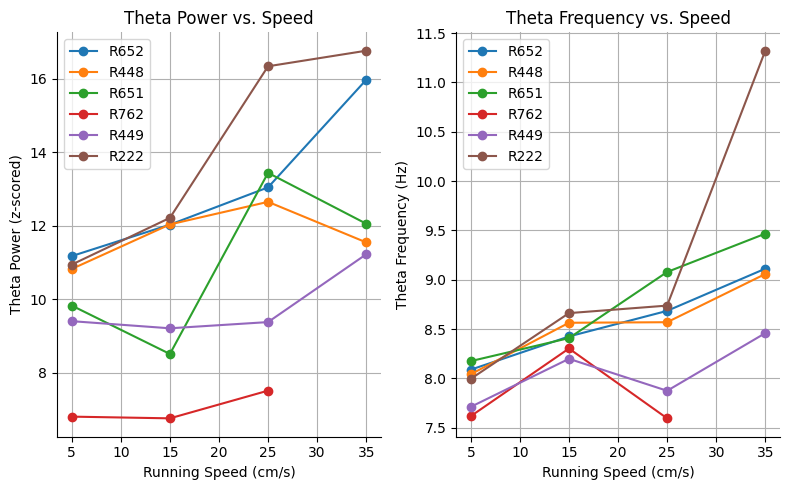

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store data for each rat
rat_data = {}

# Iterate through each session's results and store power/frequency per speed bin per rat
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)

                if data_dict is None:
                    continue

                eeg = data_dict['eeg']
                eeg_filtered = data_dict['eeg_filtered']
                eegtimes = data_dict['eegtimes']
                v = data_dict['pov']
                t = data_dict['pot']

                # Smooth speed
                # v_smoothed = gaussian_filter1d(v, sigma=1)

                # Initialize storage for each rat
                if ratname not in rat_data:
                    rat_data[ratname] = {speed_range: {'power': [], 'freq': []} for speed_range in [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50)]}
                    # rat_data[ratname] = {speed_range: {'power': [], 'freq': []} for speed_range in [(0, 20), (10,30), (20,40), (30,50)]}
                    
                # Compute power and frequency for each speed bin
                for speed_range in rat_data[ratname].keys():
                    mean_theta_power, mean_theta_frequency = compute_mean_theta_power_by_speed(
                        v, t, eeg, eegtimes, fs=fs, speed_range=speed_range, dur=1.0,
                        absolute_power=True
                    )
                    if not np.isnan(mean_theta_power):  # Avoid NaN values
                        rat_data[ratname][speed_range]['power'].append(mean_theta_power)
                        rat_data[ratname][speed_range]['freq'].append(mean_theta_frequency)

# Compute mean power and frequency for each rat across all sessions in each speed bin
speed_bins = [5, 15, 25, 35, 45]  # Midpoints of speed ranges
# speed_bins = [10, 20, 30, 40]  # Midpoints of speed ranges
all_rats_power = {}
all_rats_freq = {}

for ratname, data in rat_data.items():
    all_rats_power[ratname] = []
    all_rats_freq[ratname] = []
    
    for speed_range in data.keys():
        powers = np.array(data[speed_range]['power'])
        freqs = np.array(data[speed_range]['freq'])
        
        # Compute mean excluding NaNs
        mean_power = np.nanmean(powers) if len(powers) > 0 else np.nan
        mean_freq = np.nanmean(freqs) if len(freqs) > 0 else np.nan

        all_rats_power[ratname].append(mean_power)
        all_rats_freq[ratname].append(mean_freq)

# Plot Power vs Speed and Frequency vs Speed
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

# Plot Power vs Speed
for ratname, powers in all_rats_power.items():
    axs[0].plot(speed_bins, powers, marker='o', linestyle='-', label=ratname)
axs[0].set_xlabel("Running Speed (cm/s)")
axs[0].set_ylabel("Theta Power (z-scored)")
axs[0].set_title("Theta Power vs. Speed")
axs[0].legend()
axs[0].grid()

# Plot Frequency vs Speed
for ratname, freqs in all_rats_freq.items():
    axs[1].plot(speed_bins, freqs, marker='o', linestyle='-', label=ratname)
axs[1].set_xlabel("Running Speed (cm/s)")
axs[1].set_ylabel("Theta Frequency (Hz)")
axs[1].set_title("Theta Frequency vs. Speed")
axs[1].legend()
axs[1].grid()

sns.despine()

plt.tight_layout()



### Now let's calculate a power spectrogram with time zero align to a speed of 10cm/s 

## all data

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def extract_speed_periods(v, t, speed_range=(0, 10), dur=1):
    v_min, v_max = speed_range
    valid_indices = (v >= v_min) & (v <= v_max)  

    periods = []
    if np.any(valid_indices):  
        change_points = np.diff(valid_indices.astype(int))  
        start_indices = np.where(change_points == 1)[0] + 1  
        end_indices = np.where(change_points == -1)[0] + 1  

        if valid_indices[0]:  
            start_indices = np.insert(start_indices, 0, 0)
        if valid_indices[-1]:  
            end_indices = np.append(end_indices, len(v))

        for start, end in zip(start_indices, end_indices):
            if (t[end - 1] - t[start]) >= dur:  
                periods.append((t[start], t[end - 1]))

    return periods

def compute_time_evolving_spectrogram(eeg, eegtimes, v, t, fs=250, speed_threshold=10, dur=1, window_length=500, step_size=100, freq_range=(2, 50)):
    speed_periods = extract_speed_periods(v, t, speed_range=(speed_threshold, np.inf), dur=dur)
    aligned_spectrograms = []

    for start, end in speed_periods:
        speed_crossing_index = np.where((t >= start) & (v >= speed_threshold))[0][0]
        time_zero = t[speed_crossing_index]

        eeg_segment = eeg[(eegtimes >= time_zero - dur) & (eegtimes <= time_zero + dur)]
        if len(eeg_segment) == 0:
            continue  

        nperseg = int((window_length / 1000) * fs)  
        noverlap = int(((window_length - step_size) / 1000) * fs)  

        freqs, times, Sxx = spectrogram(eeg_segment, fs=fs, nperseg=nperseg, noverlap=noverlap, mode='psd')

        freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        Sxx = Sxx[freq_mask, :]

        times = times - dur  
        aligned_spectrograms.append(Sxx)

    if not aligned_spectrograms:
        return np.array([]), np.array([]), []

    return freqs[freq_mask], times, aligned_spectrograms

base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)

                if data_dict is None:
                    continue

                eeg, eegtimes, v, t = data_dict['eeg'], data_dict['eegtimes'], data_dict['pov'], data_dict['pot']

                print(f"Processing Rat: {ratname}")

                freqs, times, Sxx_trials = compute_time_evolving_spectrogram(eeg, eegtimes, v, t, fs=250, 
                                                                             speed_threshold=5, dur=2, 
                                                                             window_length=500, step_size=100)

                if len(Sxx_trials) == 0:
                    print(f"No valid trials for {ratname}. Skipping...")
                    continue  

                # min_length = min(Sxx.shape[1] for Sxx in Sxx_trials)
                # Sxx_trials_fixed = [Sxx[:, :min_length] for Sxx in Sxx_trials]
                #if trial lengths are different, delete those trials
                trial_lengths = [Sxx.shape[1] for Sxx in Sxx_trials]
                #delet shorter trials
                max_length = max(trial_lengths)
                Sxx_trials = [Sxx for Sxx in Sxx_trials if Sxx.shape[1] == max_length]
                Sxx_avg = np.mean(np.stack(Sxx_trials, axis=0), axis=0)

                Sxx_db = 10 * np.log10(Sxx_avg)

                baseline_idx = np.where((times >= -0.5) & (times <= 0))[0]
                baseline_power = np.mean(Sxx_db[:, baseline_idx], axis=1, keepdims=True)
                Sxx_db_norm = Sxx_db - baseline_power

                plt.figure(figsize=(8, 4))
                plt.imshow(Sxx_db_norm, aspect='auto', origin='lower',
                           extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap='jet')
                plt.colorbar(label='Relative Power Change (dB)')
                plt.axvline(0, color='k', linestyle='--', label="Speed > 10 cm/s")
                plt.legend()

                filename_base = os.path.splitext(file)[0]
                plt.savefig(f'/home/zilong/Desktop/HDPhasePrecession/figures/thetapower/{filename_base}_thetapower.png')
                plt.close()


Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Ra

Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Rat: R652
Processing Ra

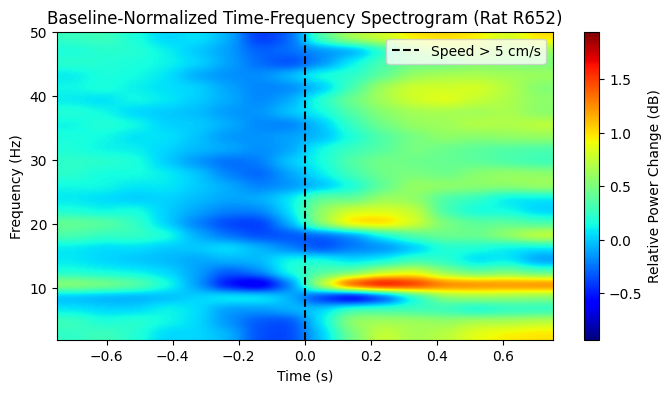

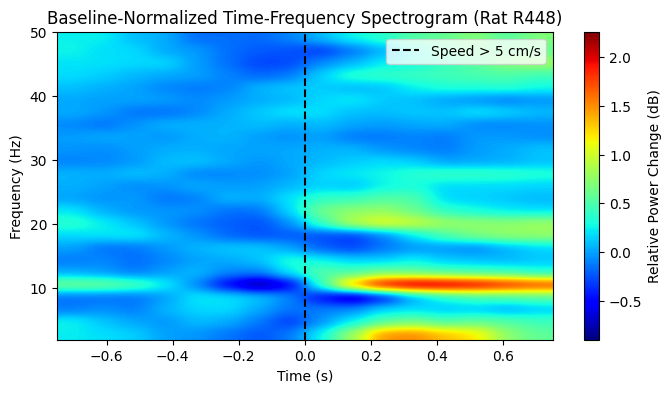

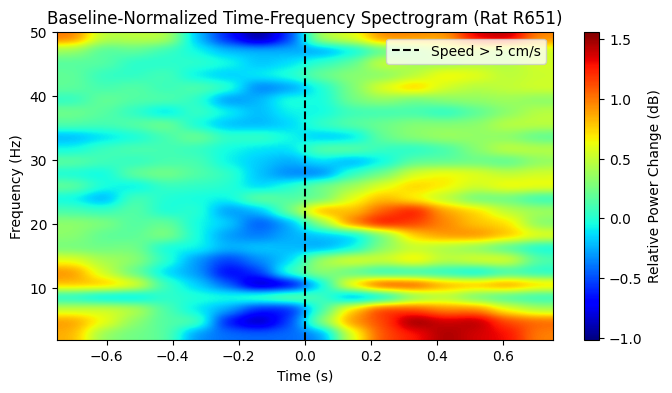

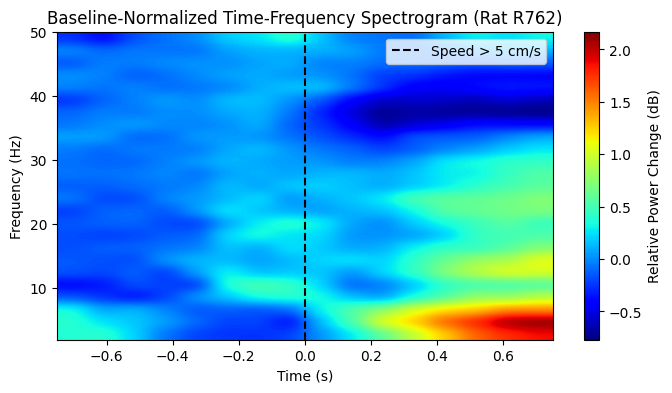

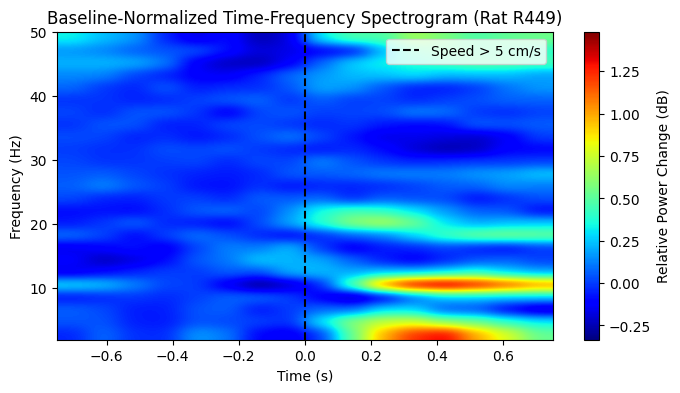

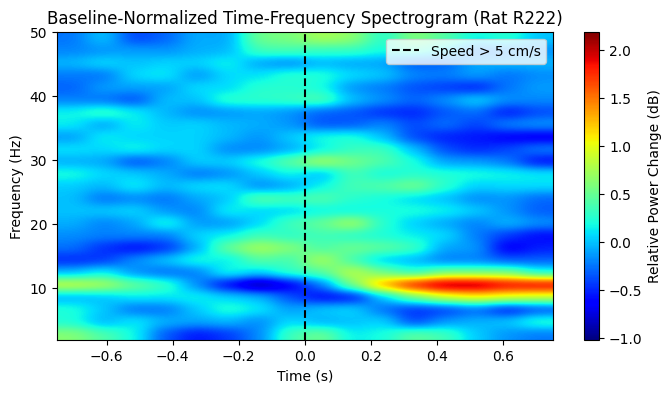

In [4]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
rat_spectrograms = {}  # Dictionary to accumulate data for each rat

for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                ratname = file.split('_')[0]  # Extract rat name from filename
                data_dict = load_data(ratname, file_path)

                if data_dict is None:
                    continue

                eeg, eegtimes, v, t = data_dict['eeg'], data_dict['eegtimes'], data_dict['pov'], data_dict['pot']

                print(f"Processing Rat: {ratname}")

                # Compute spectrogram
                dur = 1
                freqs, times, Sxx_trials = compute_time_evolving_spectrogram(
                    eeg, eegtimes, v, t, fs=250, speed_threshold=5, dur=dur, 
                    window_length=500, step_size=100
                )

                if len(Sxx_trials) == 0:
                    print(f"No valid trials for {ratname}. Skipping...")
                    continue  

                # Ensure all spectrograms have the same time bin length
                #using max_length to delete those trials with different lengths
                trial_lengths = [Sxx.shape[1] for Sxx in Sxx_trials]
                max_length = max(trial_lengths)
                Sxx_trials_fixed = [Sxx for Sxx in Sxx_trials if Sxx.shape[1] == max_length]
                

                # Store in dictionary (accumulate sessions per rat)
                if ratname not in rat_spectrograms:
                    rat_spectrograms[ratname] = []
                rat_spectrograms[ratname].extend(Sxx_trials_fixed)  # Append all sessions for this rat

# **Now process each rat and create a single plot per rat**
output_dir = "/home/zilong/Desktop/HDPhasePrecession/figures/thetapower"
os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

for ratname, Sxx_list in rat_spectrograms.items():
    if len(Sxx_list) == 0:
        continue  

    # Convert to numpy array and compute the mean across all trials of the rat
    Sxx_avg = np.mean(np.stack(Sxx_list, axis=0), axis=0)

    # Convert to dB
    Sxx_db = 10 * np.log10(Sxx_avg)

    # Baseline normalization (-0.5s to 0s before speed threshold crossing)
    baseline_idx = np.where((times >= -dur) & (times <= 0))[0]
    baseline_power = np.mean(Sxx_db[:, baseline_idx], axis=1, keepdims=True)
    Sxx_db_norm = Sxx_db - baseline_power

    # **Plot a single spectrogram for the entire rat**
    plt.figure(figsize=(8, 4))
    #gaussian smoothing Sxx_db_norm
    # Sxx_db_norm = gaussian_filter1d(Sxx_db_norm, sigma=3)
    plt.imshow(Sxx_db_norm, aspect='auto', origin='lower',
               extent=[times[0], times[-1], freqs[0], freqs[-1]], cmap='jet', interpolation='gaussian')

    plt.colorbar(label='Relative Power Change (dB)')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(f"Baseline-Normalized Time-Frequency Spectrogram (Rat {ratname})")
    plt.axvline(0, color='k', linestyle='--', label="Speed > 5 cm/s")
    plt.legend()

    # Save the figure
    # plt.savefig(os.path.join(output_dir, f"{ratname}_thetapower.png"))
    # plt.close()

print("Finished processing all rats.")
